# Generalized Linear Models : Pynapple & Nemos

In [1]:
## dandi_download_open - > remove this before uploading

import h5py
import os
import remfile

from random import randint

from dandi import download
from dandi import dandiapi
from pynwb import NWBHDF5IO


# downloads an NWB file from DANDI to download_loc, opens it, and returns the IO object for the NWB
# dandi_api_key is required to access files from embargoed dandisets
def dandi_download_open(dandiset_id, dandi_filepath, download_loc=None, dandi_api_key=None, force_overwrite=False):
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
    dandiset = client.get_dandiset(dandiset_id)

    file = dandiset.get_asset_by_path(dandi_filepath)
    file_url = file.download_url

    if download_loc == None:
        if "codeocean" in os.environ.get("GIT_ASKPASS", ""):
            download_loc = "../../scratch"
        else:
            download_loc = "."

    filename = dandi_filepath.split("/")[-1]
    filepath = f"{download_loc}/{filename}"

    if os.path.exists(filepath) and not force_overwrite:
        print("File already exists")
    else:
        download.download(file_url, output_dir=download_loc)
        print(f"Downloaded file to {filepath}")

    print("Opening file")
    io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
    return io


# streams an NWB file remotely from DANDI, opens it, and returns the IO object for the NWB
# dandi_api_key is required to access files from embargoed dandisets
def dandi_stream_open(dandiset_id, dandi_filepath, dandi_api_key=None):
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
    dandiset = client.get_dandiset(dandiset_id)

    file = dandiset.get_asset_by_path(dandi_filepath)
    base_url = file.client.session.head(file.base_download_url)
    file_url = base_url.headers["Location"]

    rem_file = remfile.File(file_url)
    h5py_file = h5py.File(rem_file, "r")
    io = NWBHDF5IO(file=h5py_file, mode="r", load_namespaces=True)
    return io

### Downloading file

In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

from math import ceil
from scipy import interpolate
from functools import reduce

from scipy.optimize import minimize
from sklearn.metrics import r2_score

import jax

#%matplotlib inline

In [24]:
import pynapple as nap

In [25]:
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

### Pynapple

Open the nwb file with pynapple

In [26]:
import pynapple as nap
import nemos as nmo

io = dandi_download_open(dandiset_id, dandi_filepath, download_loc)
nwb = io.read()

#data = nap.NWBFile("sub-726298249_ses-754829445.nwb")
file_name = "sub-726298249_ses-754829445.nwb"
data = nap.load_file(file_name)

File already exists
Opening file


/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


see data
explain different types of pynapple?

In [27]:
data

sub-726298249_ses-754829445
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                                               │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                                              │ TsGroup     │
│ static_gratings_presentations                      │ IntervalSet │
│ spontaneous_presentations                          │ IntervalSet │
│ natural_scenes_presentations                       │ IntervalSet │
│ natural_movie_three_presentations                  │ IntervalSet │
│ natural_movie_one_presentations                    │ IntervalSet │
│ gabors_presentations                               │ IntervalSet │
│ flashes_presentations                              │ IntervalSet │
│ drifting_gratings_presentations                    │ IntervalSet │
│ timestamps                                         │ Tsd         │
│ running_wheel_rotation                             │ Tsd         │
│ runn

### Extract Spiking data

In [28]:
# Identify what brain location electrodes belong to
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

print(channel_probes)

units = data["units"]

# Add a new column to include location in our spikes TsGroup
units["location"] = units["peak_channel_id"].map(channel_probes)

# Filter units 1) inn VISp, 2) with "good" quality and 3) with a firing rate larger than 2
units_visp = units[(units["location"]=="VISp") & (units["quality"]=="good") & (units["rate"]>2.0)] 

# Spike counts will be arranged later

{850135034: 'PoT', 850135036: 'PoT', 850135042: 'PoT', 850135046: 'PoT', 850135052: 'PoT', 850135058: 'PoT', 850135064: 'LP', 850135068: 'LP', 850135074: 'LP', 850135078: 'LP', 850135080: 'LP', 850135086: 'LP', 850135090: 'LP', 850135096: 'LP', 850135102: 'LP', 850135108: 'LP', 850135112: 'LGd', 850135118: 'LGd', 850135124: 'LGd', 850135130: 'LGd', 850135136: 'LGd', 850135140: 'LGd', 850135146: 'LGd', 850135152: 'LGd', 850135158: 'LGd', 850135162: 'LGd', 850135168: 'LGd', 850135174: 'LGd', 850135180: 'LGd', 850135186: 'LGd', 850135190: 'LGd', 850135196: 'LGd', 850135202: 'LGd', 850135208: 'LGd', 850135212: 'LGd', 850135218: 'LGd', 850135224: 'LGd', 850135230: 'LGd', 850135236: 'LGd', 850135240: 'LGd', 850135246: 'CA3', 850135252: 'CA3', 850135258: 'CA3', 850135262: 'CA3', 850135268: 'CA3', 850135274: 'CA3', 850135280: 'CA3', 850135286: 'CA3', 850135290: 'CA3', 850135296: 'CA3', 850135302: 'CA3', 850135308: 'DG', 850135312: 'DG', 850135318: 'DG', 850135320: 'DG', 850135326: 'DG', 850135

### Extract Stimulus Data

In [29]:
def retrieve_stim_info(color_code, features, flashes):
    """Retrieve stimulus information based on color code.

    Parameters
    ----------
    color_code : 
        The color label (e.g., '-1.0' for black, '1.0 for white) to identify the stimulus.
    features : 
        An array indicating which flash interval each timestamp belongs to.

    Returns
    ----------
    color_feature: 
        A binary array where 1 indicates the timestamp falls within a flash 
        interval of the given color_code, and 0 otherwise.
    """
    # Get the indices of flash intervals where the color matches the given color_code
    intervals = flashes.index[flashes["color"] == color_code]
    # Initialize an array of zeros with the same length as the features array
    color_feature = np.zeros(len(features))
    # Create a boolean mask for entries in 'features' that match the target flash intervals
    mask = np.isin(features, intervals)
    # Mark the matching timestamps with 1
    color_feature[mask] = 1

    return color_feature

In [43]:
flashes = data["flashes_presentations"]

# Set start, end and bin size
start = data["flashes_presentations"]["start"].min()
end = data["flashes_presentations"]["end"].max()
bin_sz = 0.050

# Set number of time bins
length = int((end-start)//bin_sz)

# Spike counts
# Provisional spike counts
drop_list = [k for k in units_visp.metadata_columns if k != "rate"]
units_visp.drop_info(drop_list)

# Create Tsd with timestamps corresponding to the desired time bins and bins sizes
spike_counts = units_visp.count(bin_sz, ep=nap.IntervalSet(start, end))
uniform = nap.Tsd(t=spike_counts.t, d=np.ones(spike_counts.shape[0]))

# For each desired timestamp, find the index of the flash interval it falls into.
# Returns NaN for timestamps outside all intervals, and an index for those within.
features = flashes.in_interval(uniform)

white_stimuli = retrieve_stim_info("1.0", features, flashes)
black_stimuli = retrieve_stim_info("-1.0", features, flashes)

In [10]:
# Plot
'''
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(uniform.times(), white_stimuli, color="silver")
axes[0].set_title("White Flashes from Session")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Presence of Flash")

axes[1].plot(uniform.times(), black_stimuli, color="black")
axes[1].set_title("Black Flashes from Session")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Presence of Flash")
'''

'\nfig, axes = plt.subplots(1,2, figsize=(15,5))\naxes[0].plot(uniform.times(), white_stimuli, color="silver")\naxes[0].set_title("White Flashes from Session")\naxes[0].set_xlabel("Time")\naxes[0].set_ylabel("Presence of Flash")\n\naxes[1].plot(uniform.times(), black_stimuli, color="black")\naxes[1].set_title("Black Flashes from Session")\naxes[1].set_xlabel("Time")\naxes[1].set_ylabel("Presence of Flash")\n'

### Nemos: Building design matrix

In [12]:
### This will be in the snippet

def build_design_mat(stim, d, include_const=True):
  # Create version of stimulus vector with zeros before onset
  padded_stim = np.concatenate([np.zeros(d-1), stim])

  # Construct a matrix where each row has the d frames of
  # the stimulus preceding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: number of stimulus frames)
  X = np.zeros((T, d))
  for t in range(T):
      X[t] = padded_stim[t:t + d]

  if include_const:
    constant = np.ones_like(stim)
    return np.column_stack([constant, X])
  return X

In [68]:
# Attempt of basis
filter_duration = 0.250 # we want a 200 ms window,

filter_length = int(filter_duration / bin_sz) # divide by bin size to yield length of filter
filter_time_bins = np.linspace(-filter_duration, 0, filter_length+1, endpoint=True)

white_basis = nmo.basis.HistoryConv(window_size=5, label="white", conv_kwargs=dict(shift=False))
black_basis = nmo.basis.HistoryConv(window_size=5,label="black",conv_kwargs=dict(shift=False))

white_basis = white_basis.compute_features(white_stimuli)
black_basis = black_basis.compute_features(black_stimuli)

X = nmo.pytrees.FeaturePytree(W=white_basis, B=black_basis) 

#model = nmo.glm.PopulationGLM(regularizer="UnRegularized", )#regularizer_strength=10**-12
#model.fit(X,spike_counts)

'''
for i in range(2):
    plt.plot(filter_time_bins[:-1], model.coef_["B"][:,i], label='Black flashes', color="black")
    plt.plot(filter_time_bins[:-1], model.coef_["W"][:,i], label='White flashes', color ="silver")
    plt.title(f"unit {i}")
    plt.show()
'''


'\nfor i in range(2):\n    plt.plot(filter_time_bins[:-1], model.coef_["B"][:,i], label=\'Black flashes\', color="black")\n    plt.plot(filter_time_bins[:-1], model.coef_["W"][:,i], label=\'White flashes\', color ="silver")\n    plt.title(f"unit {i}")\n    plt.show()\n'

In [45]:
from jax.tree_util import tree_leaves
X = nmo.pytrees.FeaturePytree(W=white_basis, B=black_basis)
X_1  = np.hstack(tree_leaves(X))
np.linalg.eigh(X_1[filter_length:].T@X_1[filter_length:])[0]


array([  40.58394 ,   41.13237 ,   56.53097 ,   57.294903,   94.25903 ,
         95.53281 ,  387.46902 ,  392.7051  , 1271.157   , 1288.3348  ],
      dtype=float32)

### Fitting with different solvers?

In [89]:
jax.config.update("jax_enable_x64", True)

# Design matrix
X = np.hstack([white_basis,black_basis]) # We decided to use hstack because with that our matrix matches theirs. When we use Pytree it doesnt
spike_counts.sum(axis=0)
np.where(spike_counts.sum(axis=0)==1267)

(array([117]),)

In [63]:
models = []
for unit in range(spike_counts.shape[1]):
    model = nmo.glm.GLM(solver_name="LBFGS", solver_kwargs=dict(tol=10**-12))
    model.fit(X,spike_counts[:,unit])
    models.append(model)

    print(model.solver_state_[0])
    print(model.coef_)
    model.score(X,spike_counts[:,unit])

70
[ 0.12560783 -0.24669623  0.36560941 -0.36560941 -0.1210884  -0.1329435
  0.3466884   0.38075534 -0.43052152  0.06419907]
81
[-0.06510606  0.018267   -0.01217838  0.07911113 -0.11377181 -0.07285274
  0.07157494 -0.0775308   0.13714551 -0.08476214]
67
[ 0.20050938 -0.54587339  0.15613618  0.612393   -0.13521963 -0.13885344
 -0.46948172 -0.23128672  0.29386309  0.40967514]
76
[-0.62543992  0.36556601  0.208187    0.19034108 -0.25400321  0.81109901
 -0.09771217 -0.19461053  0.12162508 -0.11762101]
141
[  0.86588739 -73.35211916  31.87602992  42.16923642 -73.17937895
   1.13849265  -1.47701754   1.47701754   0.51839068  -0.85691557]
86
[ 0.15393712  0.14171704  0.03376443 -0.1705635   0.06042785 -0.91332898
 -0.22881315  0.45532336 -0.27437882  0.02793988]
74
[-0.12203988 -0.7455079   0.7455079  -1.35259999  0.48505221 -1.96719359
  1.05213407  0.38899595  0.38899595 -0.91505952]
81
[-0.18078192 -1.44313581  2.40319438  0.28309624  0.30170098  1.54289022
  1.78872489 -1.17404754 -0.4357

In [85]:
n_features =10
n_neurons = 124
coef_ = np.zeros((n_features, n_neurons))
intercept_ = np.zeros(n_neurons)

for neuron in range(n_neurons):
    coef_[:,neuron] = models[neuron].coef_
    intercept_[neuron] = models[neuron].intercept_[0]

In [94]:
pop_model = nmo.glm.PopulationGLM()

pop_model.coef_ = coef_
pop_model.intercept_ = intercept_

## Plot coefficients


## Evaluate

In [ ]:
full_scores = pop_model.score(
	X, spike_counts, aggregate_sample_scores=lambda x:np.mean(x, axis=0), score_type="pseudo-r2-McFadden"
)

white_scores = pop_model.score(
	X, spike_counts, aggregate_sample_scores=lambda x:np.mean(x, axis=0), score_type="pseudo-r2-McFadden"
)

black_scores

<BarContainer object of 124 artists>

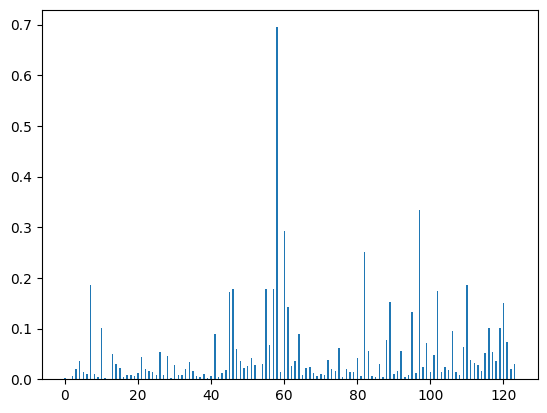

In [96]:
plt.bar(np.arange(0, n_neurons), full_scores, 0.4, label="Full model")

In [ ]:
# They dont use train&test here?


In [ ]:
pop_model.predict()

take firing rate prediction/time
calculate mean firing rate
compare mean firing rate of y

should be close

fit nemos to their exact data

add 
- basis construction from compare_likelihood
- Use ridge